In [1]:
# import optuna
# import re
import matplotlib.pyplot as plt
# import numpy as np
import seaborn as sns
import pandas as pd
# from tqdm import tqdm
# from pathlib import Path

from engine.cd_plot import draw_cd_diagram

/mnt/linux/sync/research/rethinking_encoder_warmstart/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# models = ["logistic", "xgboost"]

In [20]:
# def suffix_func(name):
#     if "liltab" in name:
#         return "liltab"
#     if "d2v_warmstart" in name:
#         return "d2v"
#     if "rank" in name:
#         return "rank"
#     return "baseline"

In [21]:
# # sufix_func = lambda name: 'liltab' if 'liltab' in name else ('d2v' if 'd2v_warmstart' in name else 'baseline')
# def model_name_func(name):
#     for model in models:
#         if model in name:
#             return model
        
# name_re = re.compile('(.*-[0-9]+)_')

In [22]:
# def generate_plot_df(study_path):
#     res = optuna.get_all_study_summaries(f"sqlite:///{study_path}")
#     study_full_names = list(map(lambda study: study.study_name, res))
#     study_methods = list(map(lambda name: suffix_func(name), study_full_names))
#     study_models = list(map(lambda name: model_name_func(name), study_full_names))
#     study_names = list(map(lambda m: re.split(r"_logistic|_xgboost", m)[0], study_full_names))

#     p_bar = tqdm(
#         (zip(study_names, study_methods, study_models, study_full_names)), total=len(study_names)
#     )

#     df = pd.DataFrame()

#     for name, method, model, full_name in p_bar:
#         study = optuna.load_study(study_name=full_name, storage=f"sqlite:///{study_path}")

#         study_scores = list(map(lambda trail: trail.value, study.trials))
#         study_scores_best = list(np.maximum.accumulate(study_scores))
#         study_number = list(map(lambda trail: trail.number, study.trials))
#         n = len(study_number)

#         new_record = pd.DataFrame(
#             {
#                 "score": study_scores_best,
#                 "no": study_number,
#                 "method": [method for _ in range(n)],
#                 "model": [model for _ in range(n)],
#                 "name": [name for _ in range(n)],
#             }
#         )
#         df = pd.concat([df, new_record])
#     return df

In [6]:
# paths = list(Path("results/warmstart_dbs/uci").iterdir())

In [23]:
# plot_dfs = list(map(generate_plot_df, tqdm(paths)))

In [24]:
# for i, d in enumerate(plot_dfs):
    # d["fold"] = i

In [25]:
# df = pd.concat(plot_dfs, axis=0)

In [26]:
# df.to_csv("results/warmstart_plots/uci_df.csv", index=False)

## Count of tasks when method is best in i-th iteration

In [27]:
df = pd.read_csv("results/warmstart_plots/uci_df.csv")

In [28]:
df_grouped = df.sort_values("score").groupby(["fold", "name", "model", "no"]).last().reset_index()
results = df_grouped.groupby(["fold", "no", "model", "method"]).count().reset_index()

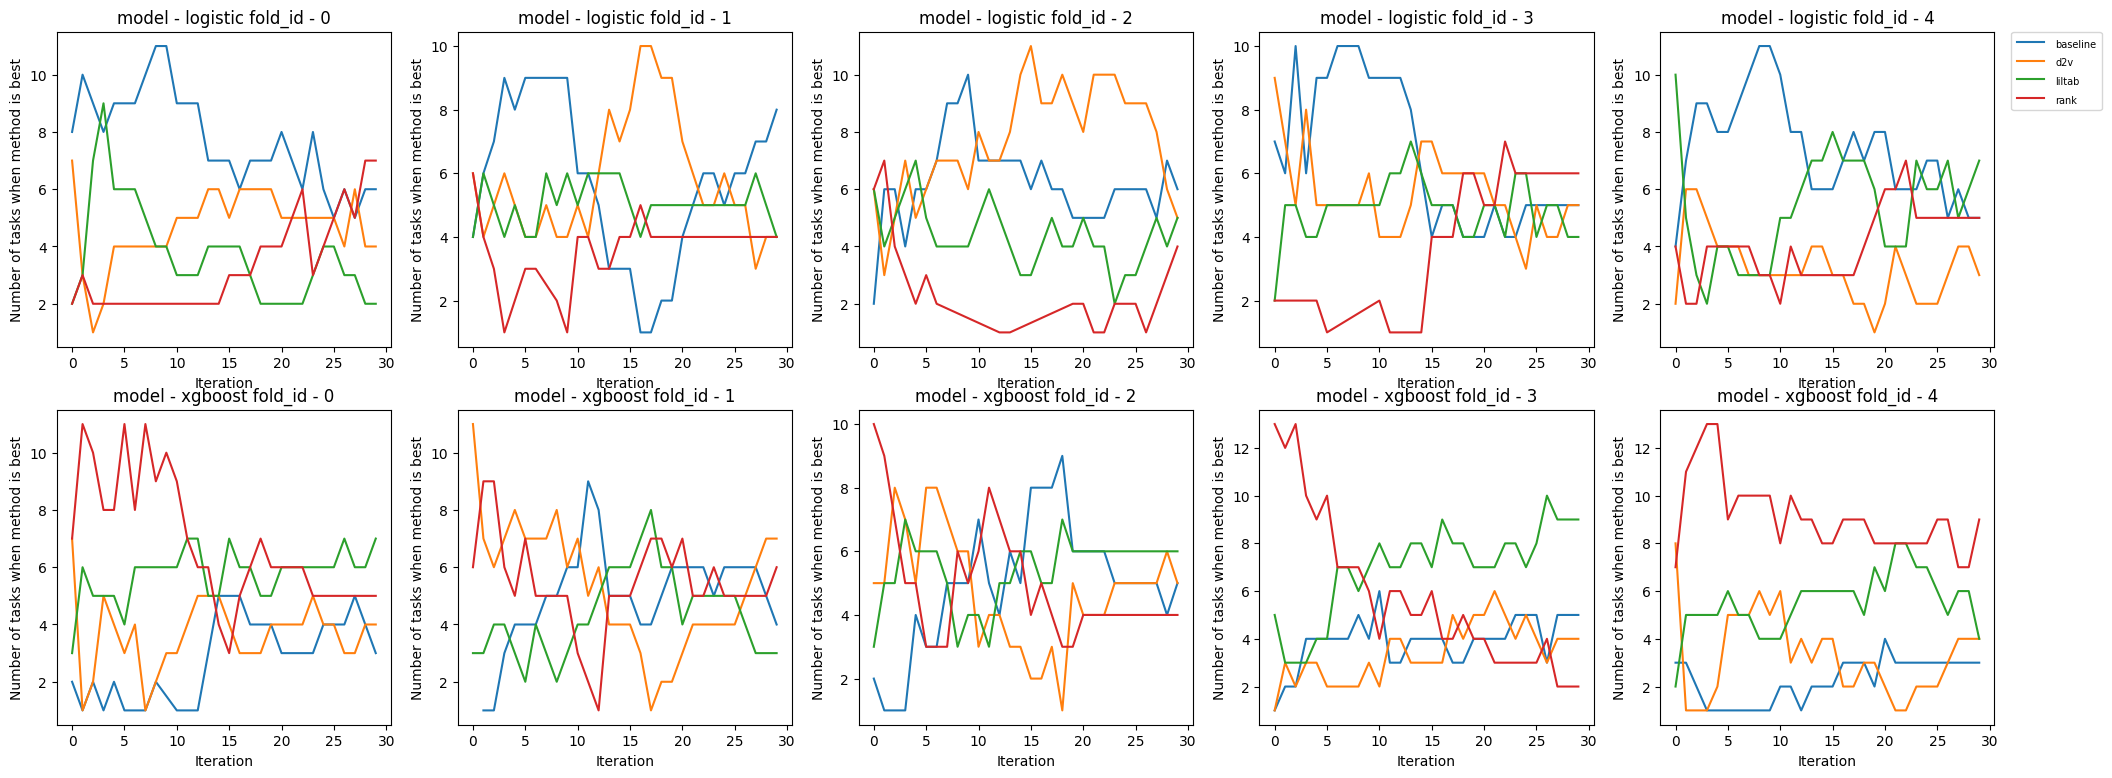

In [29]:
models = ["logistic", "xgboost"]
fold_ids = list(range(5))

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(25, 9))

for i, model in enumerate(models):
    for j, fold in enumerate(fold_ids):
        p = sns.lineplot(
            results[(results["model"] == model) & (results["fold"] == fold)].sort_values("method"),
            x="no",
            y="score",
            hue="method",
            ax=ax[i][j],
        )
        p.set_ylabel("Number of tasks when method is best")
        p.set_xlabel("Iteration")
        p.set_title(f"model - {model} fold_id - {fold}")
        if i == 0 and j == len(fold_ids) - 1:
            p.legend(loc=(1.05, .75))
            plt.setp(p.get_legend().get_title(), fontsize=7)
            plt.setp(p.get_legend().get_texts(), fontsize=7)
        else:
            p.legend([], [], frameon=False)


## Average rank in i-th iteration

In [ ]:
# ranks = df.groupby(['run_id', 'name', 'model', 'no'])['score'].rank('average', ascending=False)
# df_copy = df.copy()
# df_copy['rank'] = ranks

# rank_df = df_copy.groupby(['run_id', 'no', 'model', 'method']).mean('rank').reset_index()

In [ ]:
# sns.lineplot(rank_df[rank_df["model"] == "logistic"], x="no", y="rank", hue="method").set_title(
#     "Average rank in i-th iteration"
# )

## ADTM

In [30]:
scores_min_max = (
    df.groupby(["fold", "name", "model"], as_index=False)
    .agg({"score": ["min", "max"]})
    .reset_index(drop=False)
)
scores_min_max.columns = scores_min_max.columns.get_level_values(0)
scores_min_max.columns = scores_min_max.columns[:-2].tolist() + ["min", "max"]

df_with_min_max = df.merge(scores_min_max, how="left", on=["fold", "name", "model"])
df_with_min_max["score"] = (df_with_min_max["score"] - df_with_min_max["min"]) / (
    df_with_min_max["max"] - df_with_min_max["min"]
)
df_with_min_max["max_minus_score"] = 1 - df_with_min_max["score"]
df_with_min_max = df_with_min_max[["fold", "name", "model", "method", "no", "max_minus_score"]]

In [31]:
df_with_min_max.loc[df_with_min_max.max_minus_score == 0].groupby(["model", "method"]).agg(
    {"name": lambda x: x.nunique()}
)

name
model    method        
logistic baseline    42
         d2v         37
         liltab      38
         rank        37
xgboost  baseline    31
         d2v         36
         liltab      41
         rank        37

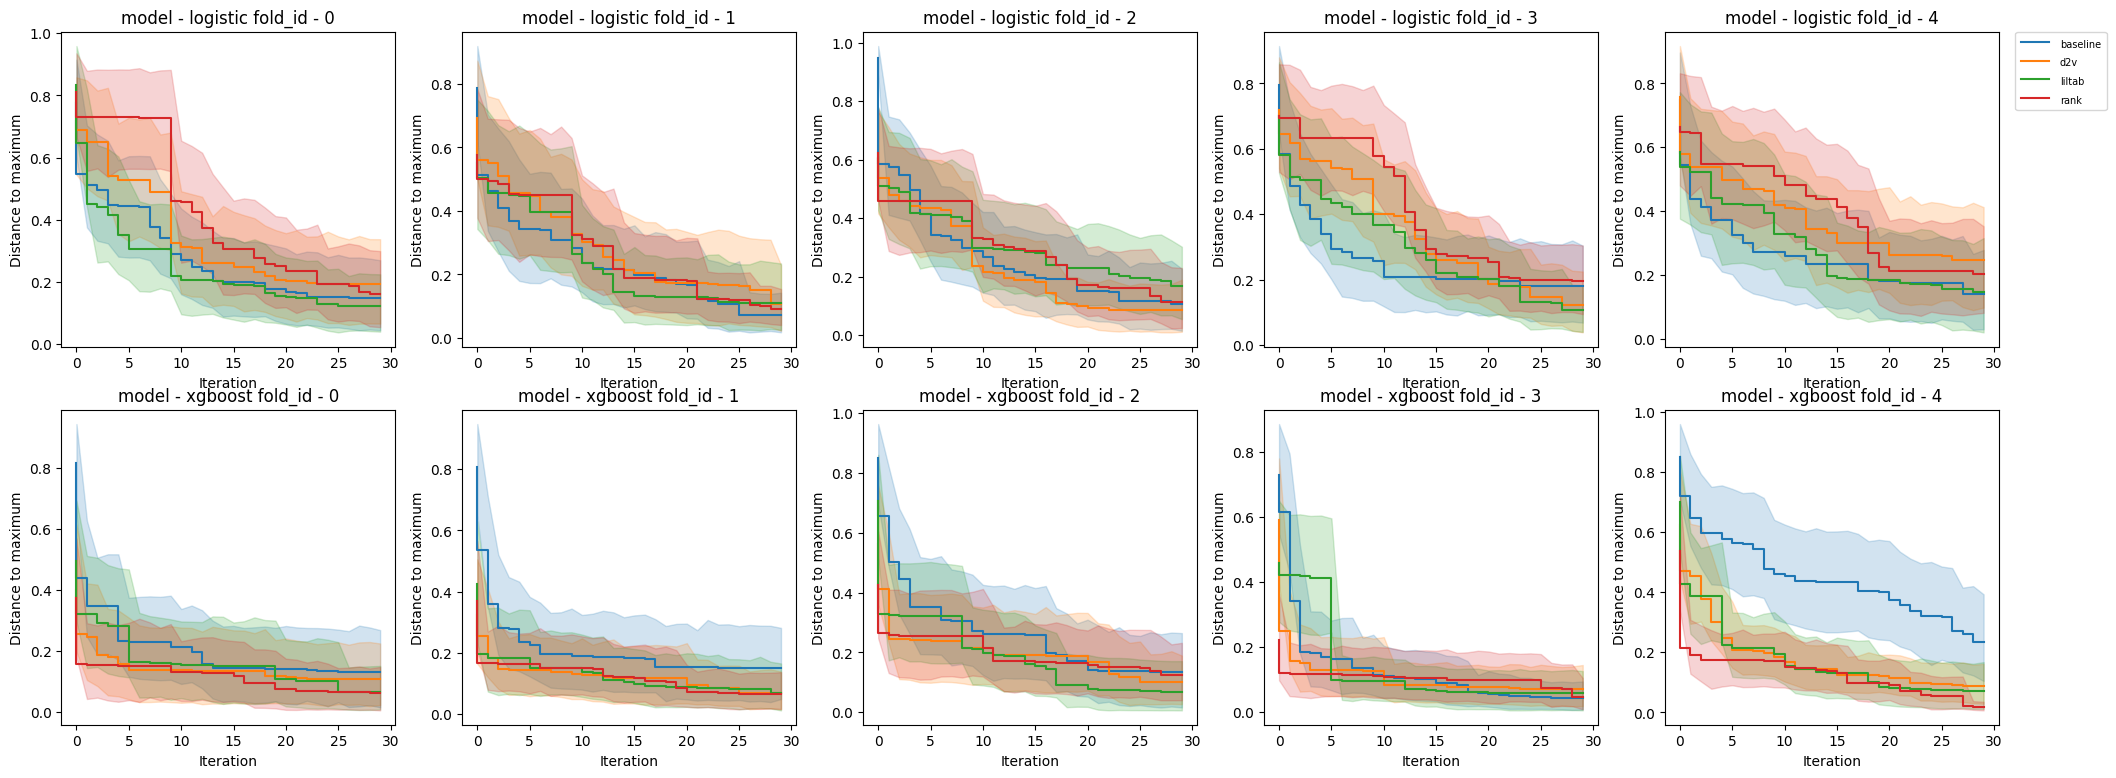

In [32]:
models = ["logistic", "xgboost"]
fold_ids = list(range(5))

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(25, 9))

for i, model in enumerate(models):
    for j, fold in enumerate(fold_ids):
        p = sns.lineplot(
            df_with_min_max[
                (df_with_min_max["model"] == model) & (df_with_min_max["fold"] == fold)
            ].sort_values("method"),
            x="no",
            y="max_minus_score",
            hue="method",
            drawstyle="steps",
            ax=ax[i][j],
        )
        p.set_ylabel("Distance to maximum")
        p.set_xlabel("Iteration")
        p.set_title(f"model - {model} fold_id - {fold}")
        if i == 0 and j == len(fold_ids) - 1:
            p.legend(loc=(1.05, 0.75))
            plt.setp(p.get_legend().get_title(), fontsize=7)
            plt.setp(p.get_legend().get_texts(), fontsize=7)
        else:
            p.legend([], [], frameon=False)

['rank' 'baseline' 'd2v' 'liltab']
rank        3.279570
d2v         2.575269
liltab      2.344086
baseline    1.801075
dtype: float64
('baseline', 'd2v', nan, False)
('baseline', 'liltab', nan, False)
('baseline', 'rank', nan, False)
('d2v', 'liltab', nan, False)
('d2v', 'rank', nan, False)
('liltab', 'rank', nan, False)
Index(['rank', 'd2v', 'liltab', 'baseline'], dtype='object')
[0, 1, 2, 3]
['rank' 'baseline' 'd2v' 'liltab']
rank        2.591398
d2v         2.532258
liltab      2.489247
baseline    2.387097
dtype: float64
('baseline', 'd2v', nan, False)
('baseline', 'liltab', nan, False)
('baseline', 'rank', nan, False)
('d2v', 'liltab', nan, False)
('d2v', 'rank', nan, False)
('liltab', 'rank', nan, False)
Index(['rank', 'd2v', 'liltab', 'baseline'], dtype='object')
[0, 1, 2, 3]
['rank' 'baseline' 'd2v' 'liltab']
baseline    3.036082
liltab      2.500000
d2v         2.242268
rank        2.221649
dtype: float64
('baseline', 'd2v', nan, False)
('baseline', 'liltab', nan, False)
('bas

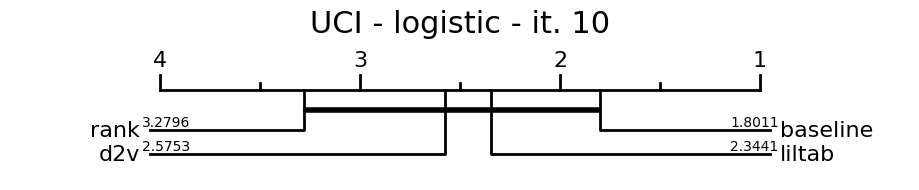

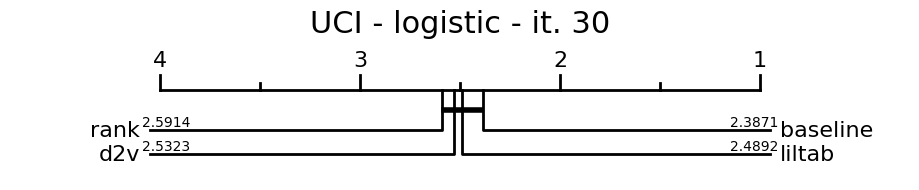

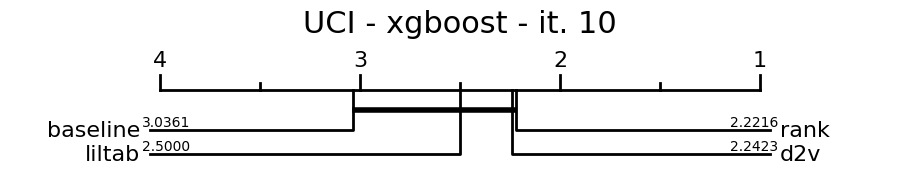

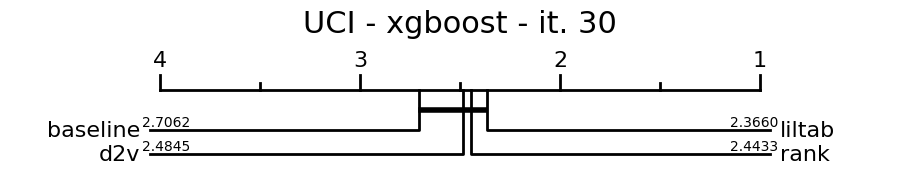

In [33]:
models = ["logistic", "xgboost"]
iterations = [9, 29]
for model in models:
    for it in iterations:
        df_to_cd = (
            df_with_min_max.loc[(df_with_min_max.no == it) & (df_with_min_max.model == model)]
            .rename(
                columns={
                    "method": "classifier_name",
                    "name": "dataset_name",
                    "max_minus_score": "accuracy",
                }
            )[["classifier_name", "dataset_name", "accuracy"]]
            .reset_index(drop=True)
        )
        df_to_cd["accuracy"] = 1 - df_to_cd["accuracy"]
        draw_cd_diagram(
            f"results/warmstart_plots/uci_{model}_{it + 1}.png",
            df_perf=df_to_cd,
            title=f"UCI - {model} - it. {it + 1}",
            labels=True,
        )